In [278]:
import warnings
warnings.filterwarnings('ignore')

In [279]:
import numpy as np
import pandas as pd
import re, random, time
from  sklearn.metrics import mean_squared_log_error 
from  sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
pd.options.display.max_columns = 1000

In [314]:
df_train = pd.read_csv('train/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")
fulfilment_center_info = pd.read_csv('train/fulfilment_center_info.csv')
meal_info = pd.read_csv('train/meal_info.csv')

In [315]:
df_train = df_train.merge(fulfilment_center_info, how = 'left', on = 'center_id')
df_train = df_train.merge(meal_info, how = 'left', on = 'meal_id')
df_train['Istrain'] = 1

df_test = df_test.merge(fulfilment_center_info, how = 'left', on = 'center_id')
df_test = df_test.merge(meal_info, how = 'left', on = 'meal_id')
df_test['Istrain'] = 0

df_all = df_train.append(df_test)
df_all = df_all[df_all.week > 100]
print(df_test.shape, df_train.shape, df_all.shape)
df_all.tail(2)

(32573, 15) (456548, 16) (179824, 16)


,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week
32571,0,323.07,Salad,61,TYPE_A,322.07,473,Italian,0,0,1444235,2569,NaN,4.5,77,155
32572,0,276.45,Salad,61,TYPE_A,276.45,473,Italian,0,0,1291286,2490,NaN,4.5,77,155


In [318]:
avg_price_meal = df_all[['meal_id', 'base_price', 'checkout_price']].groupby('meal_id', as_index = False).mean()
avg_price_meal.columns = ['meal_id', 'avg_base_price_meal', 'avg_checkout_price_meal']
df_all = df_all.merge(avg_price_meal, how = 'left', on='meal_id')

avg_price_center = df_all[['center_id', 'base_price', 'checkout_price']].groupby('center_id', as_index = False).mean()
avg_price_center.columns = ['center_id', 'avg_base_price_center', 'avg_checkout_price_center']
df_all = df_all.merge(avg_price_center, how = 'left', on='center_id')

# categorical to numeric

In [320]:
cat_columns = [x for x in df_all.columns if df_all[x].dtype == 'O']
for col in cat_columns:
    df_all[col] = pd.factorize(df_all[col])[0]
df_all.head(2)

,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center
0,1,148.41,0,55,0,150.41,647,0,0,0,1117603,1885,242.0,2.0,56,101,134.066808,131.569177,356.627821,331.665534
1,1,150.38,0,55,0,151.38,647,0,0,0,1234967,1993,364.0,2.0,56,101,133.893845,131.774290,356.627821,331.665534


In [321]:
df_all.tail(2)

,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center
179822,0,323.07,11,61,2,322.07,473,2,0,0,1444235,2569,NaN,4.5,77,155,309.738657,302.364965,365.729666,346.15915
179823,0,276.45,11,61,2,276.45,473,2,0,0,1291286,2490,NaN,4.5,77,155,275.698266,268.471351,365.729666,346.15915


# create rolling num of orders column 

In [322]:
for i in [10]:
    print (i, df_all.shape)
    df_all_sorted = df_all[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                        ['center_id', 'meal_id', 'week'])
    temp1 = df_all_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
    temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: x.shift()\
            .rolling(min_periods = 1, window = i).mean()).reset_index(name ='num_orders_' + str(i) + '_week')
    df_all = df_all.merge(temp2, how = 'left', on = ['center_id', 'meal_id', 'week'])
    
df_all.head()

10 (179824, 20)


,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center,num_orders_10_week
0,1,148.41,0,55,0,150.41,647,0,0,0,1117603,1885,242.0,2.0,56,101,134.066808,131.569177,356.627821,331.665534,NaN
1,1,150.38,0,55,0,151.38,647,0,0,0,1234967,1993,364.0,2.0,56,101,133.893845,131.774290,356.627821,331.665534,NaN
2,1,148.44,0,55,0,149.44,647,0,0,0,1438865,2539,216.0,2.0,56,101,134.447554,132.124974,356.627821,331.665534,NaN
3,1,308.49,0,55,0,308.49,647,1,0,0,1190381,2139,15.0,2.0,56,101,291.530320,290.480827,356.627821,331.665534,NaN
4,1,153.26,0,55,0,96.09,647,1,0,0,1027460,2631,80.0,2.0,56,101,155.105565,131.498419,356.627821,331.665534,NaN


In [323]:
for col in [x for x in df_all.columns if df_all[x].dtype != 'O' and x != 'Istrain']:
    temp = df_all[(~df_all.num_orders.isnull()) & (~df_all[col].isnull())]
    print (col, np.round(pearsonr(temp.num_orders, temp[col])[0],5) )

base_price -0.2152
category -0.18714
center_id -0.06586
center_type 0.03548
checkout_price -0.26679
city_code 0.048
cuisine -0.04567
emailer_for_promotion 0.28384
homepage_featured 0.28437
id 0.00019
meal_id 0.00614
num_orders 1.0
op_area 0.19561
region_code 0.03298
week -0.03221
avg_base_price_meal -0.22545
avg_checkout_price_meal -0.22523
avg_base_price_center 0.08925
avg_checkout_price_center 0.07291
num_orders_10_week 0.73613


In [324]:
df_all.shape, df_test.shape, df_train.shape

((179824, 21), (32573, 15), (456548, 16))

In [325]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df_all)

In [326]:
# df_all[(df_all.center_id == 23) & (df_all.meal_id == 1198)].iloc[:,[12,15,24,25,26,27,28,29,30,31,32,33]].tail(20)
# iloc[:,[12,15,24,25,26,27,28,29,30,31,32]]

# separating train and test dataset

In [327]:
df_train = df_all[df_all.week < 146].reset_index(drop =  True).drop('Istrain', axis = 1)
df_test = df_all[df_all.week >= 146].reset_index(drop = True).drop('Istrain', axis = 1)
print(df_test.shape, df_train.shape, df_all.shape)

(32573, 20) (147251, 20) (179824, 21)


# splitting train into train and valid dataset

In [328]:
df_train1 = df_train[df_train.week <= 135].sample(frac=1)
df_valid1 = df_train[df_train.week > 135]
print(df_train1.shape, df_valid1.shape)

(114430, 20) (32821, 20)


In [329]:
train_X_all = df_train.drop(['week', 'id', 'num_orders', 'center_id', 'meal_id',], axis = 1)
train_Y_all = df_train.num_orders
train_X = df_train1.drop(['week', 'id','num_orders', 'center_id', 'meal_id',], axis = 1)
train_Y = df_train1.num_orders
valid_X = df_valid1.drop(['week', 'id','num_orders', 'center_id', 'meal_id',], axis = 1)
valid_Y = df_valid1.num_orders
test_X = df_test.drop(['week', 'id', 'num_orders', 'center_id', 'meal_id',], axis = 1)
print(train_X.shape, train_Y.shape, test_X.shape, valid_X.shape)

(114430, 15) (114430,) (32573, 15) (32821, 15)


In [330]:
def rmsle(y_hat, data):
#     print (data)
    y_true = data.get_label() # scikits f1 doesn't like probabilities
    y_hat[y_hat < 0] = 0
    return 'RMSLE', -np.sqrt(mean_squared_log_error(y_true, y_hat)) * 100, True

# hyperparameter search

In [331]:
# from hyperopt import hp
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# # X_train, X_test, y_train, y_test

# def score(params):
#     print ("Training with params : ")
#     print (params)
#     num_round = int(params['n_estimators'])
#     del params['n_estimators']
#     dtrain = lgb.Dataset(train_X, label = train_Y.values)
#     dvalid = lgb.Dataset(valid_X, label = valid_Y.values)
#     # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
#     model = lgb.train(params, dtrain, num_round)
#     print ('model.best_iteration', model.best_iteration)
#     predictions = model.predict(valid_X)
#     score = np.sqrt(mean_squared_log_error(valid_Y, predictions)) * 100
#     print ("\tScore {0}\n\n".format(score))
#     return {'loss': score, 'status': STATUS_OK}

# def optimize(trials):
#     space = {
#              'n_estimators' : hp.quniform('n_estimators', 300, 4000, 1),
#              'learning_rate' : hp.quniform('learning_rate', 0.005, 0.5, 0.025),
#              'max_depth' : hp.choice('max_depth', np.arange(1, 13, dtype=int)),
#              'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1), 
#              'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#              'lambda_l1' : hp.quniform('lambda_l1', 0, 1, 0.05),
#              'lambda_l2' : hp.quniform('lambda_l2', 0.5, 1, 0.05),
#              'cat_l2' : hp.quniform('cat_l2', 0.5, 1, 0.05),
#              'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.05),
#              'metric': 'rmsle',
#              'objective': 'gamma',
#              'nthread' : 6,
#              'silent' : 1
#              }

#     best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals= 40)
#     print (best)
    
# #Trials object where the history of search will be stored
# trials = Trials()
# optimize(trials)

In [332]:
# results = trials.best_trial['misc']['vals']
# results

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's RMSLE: -52.0159
[200]	valid_0's RMSLE: -50.7941
[300]	valid_0's RMSLE: -50.3426
[400]	valid_0's RMSLE: -50.074
[500]	valid_0's RMSLE: -49.8834
[600]	valid_0's RMSLE: -49.7615
[700]	valid_0's RMSLE: -49.6404
[800]	valid_0's RMSLE: -49.5745
[900]	valid_0's RMSLE: -49.5067
[1000]	valid_0's RMSLE: -49.4491
[1100]	valid_0's RMSLE: -49.4155
[1200]	valid_0's RMSLE: -49.3875
[1300]	valid_0's RMSLE: -49.368
[1400]	valid_0's RMSLE: -49.3556
[1500]	valid_0's RMSLE: -49.3359
[1600]	valid_0's RMSLE: -49.332
[1700]	valid_0's RMSLE: -49.3196
[1800]	valid_0's RMSLE: -49.3321
[1900]	valid_0's RMSLE: -49.3337
Early stopping, best iteration is:
[1711]	valid_0's RMSLE: -49.3178
Plot feature importances...


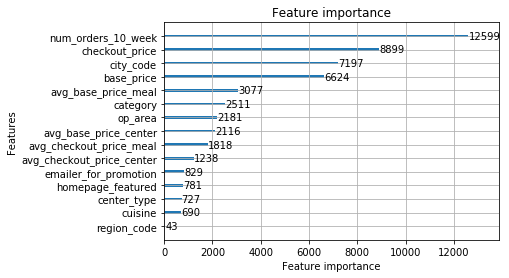

In [333]:
params = { 
    'learning_rate': 0.05, 
    'boosting': 'gbdt', 
    'objective': 'gamma', 
    'metric': 'rmsle',
    'is_training_metric': True, 
    'seed': 0 
}

fit_model = lgb.train( params, train_set= lgb.Dataset(train_X, label=train_Y.values), num_boost_round= 5000,
            valid_sets = [lgb.Dataset(valid_X, label=valid_Y.values)], feval = rmsle,  verbose_eval = 100, \
            categorical_feature=['region_code','city_code', 'category',\
                                 'center_type', 'cuisine']  ,early_stopping_rounds = 200)

valid_pred = fit_model.predict(valid_X, num_iteration=fit_model.best_iteration)
train_pred = fit_model.predict(train_X, num_iteration=fit_model.best_iteration)
test_pred = fit_model.predict(test_X, num_iteration=fit_model.best_iteration)

print('Plot feature importances...')
ax = lgb.plot_importance(fit_model, max_num_features=20)
plt.show()

# train on full data

In [306]:
fit_model.best_iteration

3485

In [308]:
n_rounds = int(len(train_X_all)/len(train_X) * fit_model.best_iteration)
final_model = lgb.train( params, train_set= lgb.Dataset(train_X_all, label=train_Y_all.values), \
                      num_boost_round= n_rounds, feval = rmsle,  verbose_eval = 50, \
            categorical_feature=['region_code','city_code', 'category', 'center_type', \
                                 'cuisine'])

In [309]:
test_pred = final_model.predict(test_X, num_iteration=n_rounds)

In [310]:
submission = pd.read_csv('sample_submission_hSlSoT6.csv')
submission.num_orders = test_pred
submission.num_orders = [0 if x <= 0 else x for x in submission.num_orders ]
submission.head(2)

,id,num_orders
0,1028232,92.159214
1,1127204,105.389808


In [311]:
submission.to_csv('lgb_gamma_0.05_0.4855_avg10_only.csv', index=False)